In [1]:
import itertools
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy

In [2]:
global_borders_min = 0.
global_borders_max = 500.

In [3]:
@dataclass
class Point:
    x: float
    y: float

In [4]:
@dataclass
class Rectangle():
    left_down: Point
    right_up: Point

In [5]:
def load_data(filename):
    rectangles = {}
    points = {}
    with open(filename, 'r') as f:
        data = f.readlines()
    n = len(data)
    for i, line in enumerate(data):
        point, sizes, poses = line.split('\t')
        x, y = map(int, point.split(','))
        width, height = map(int, sizes.split(','))
        for j, pos in enumerate(poses.split(' ')):
            p_x, p_y = map(int, pos.split(','))
            rec = Rectangle(
                Point(x - int(p_x), y - int(p_y)), 
                Point(x - int(p_x) + width, y - int(p_y) + height)
            )
            rectangles[i + n * j] = rec
        points[i] = Point(x, y)
    return n, rectangles, points
        

In [6]:
def is_rectangle_valid(rec):
    return   rec.left_down.x >= global_borders_min\
        and (rec.left_down.y >= global_borders_min)\
        and (rec.right_up.x <= global_borders_max)\
        and (rec.right_up.y <= global_borders_max)

In [7]:
def is_no_rectangles_intersect(rec1: Rectangle, rec2: Rectangle):
    no_x_intersect = (rec1.left_down.x > rec2.right_up.x) or (rec1.right_up.x < rec2.left_down.x)
    no_y_intersect = (rec1.left_down.y > rec2.right_up.y) or (rec1.right_up.y < rec2.left_down.y)
    return no_x_intersect or no_y_intersect

In [8]:
def inv(v, n):
    return v + (-n if v >= n else n)

In [9]:
def create_graphs(n, rectangles):
    g = defaultdict(set)
    gt = defaultdict(set)
    for v_ind, u_ind in itertools.combinations(range(n), 2):
        for v_add, u_add in itertools.product([0, n], repeat=2):
            v = v_ind + v_add
            u = u_ind + u_add               

            if not is_no_rectangles_intersect(rectangles[v], rectangles[u]) \
              or not is_rectangle_valid(rectangles[v]) \
              or not is_rectangle_valid(rectangles[u]):
                g[v].add(inv(u, n))
                g[u].add(inv(v, n))
                gt[inv(u, n)].add(v)
                gt[inv(v, n)].add(u)
    return g, gt

In [10]:
def dfs1(v, used, g_, order):
    used[v] = True
    
    for to in g_[v]:
        if to not in used:
            dfs1(to, used, g_, order)
    order.append(v)

In [11]:
def dfs2(v, cluster, g_, components):
    components[v] = cluster
    for to in g_[v]:
        if to not in components:
            dfs2(to, cluster, g_, components)

In [12]:
def solve_2sat(n, g, gt):
    used = {}
    order = []
    for v in range(2 * n):
        if v not in used:
            dfs1(v, used, g, order)
            
    components = {}
    cluster = 0
    for v in reversed(order):
        if v not in components:
            dfs2(v, cluster, gt, components)
            cluster += 1            
    
    for i in range(n):
        if components[i] == components[i + n]:
            return None
    result = {}
    for i in range(n):
        result[i] = components[i] < components[i + n]
    return result
        

In [13]:
def draw_rectangle(ax, rectangle):
    rect = patches.Rectangle((rectangle.left_down.x, rectangle.left_down.y), 
                             rectangle.right_up.x - rectangle.left_down.x, 
                             rectangle.right_up.y - rectangle.left_down.y, 
                             linewidth=1, edgecolor='g', facecolor=numpy.random.rand(3,), alpha=0.3)
    ax.add_patch(rect)

In [14]:
def draw_point(ax, point):
    ax.plot(
        [point.x], [point.y], 
        marker='o', markersize=5, color="red"
    )

In [15]:
def solve_label_placement(filename, lims=(0,500)):
    n, rectangles, points = load_data(filename)
    g, gt = create_graphs(n, rectangles)
    result = solve_2sat(n, g, gt)
    if not result:
        print("NO SOLUTION")
        return
    answer = []
    for v, is_upper in result.items():
        v_ = v + n * is_upper
        answer.append(rectangles[v_])

    fig, ax = plt.subplots(figsize=(20, 20))
    for rec in answer:
        draw_rectangle(ax, rec)
    for _, point in points.items():    
        draw_point(ax, point)
    plt.show()

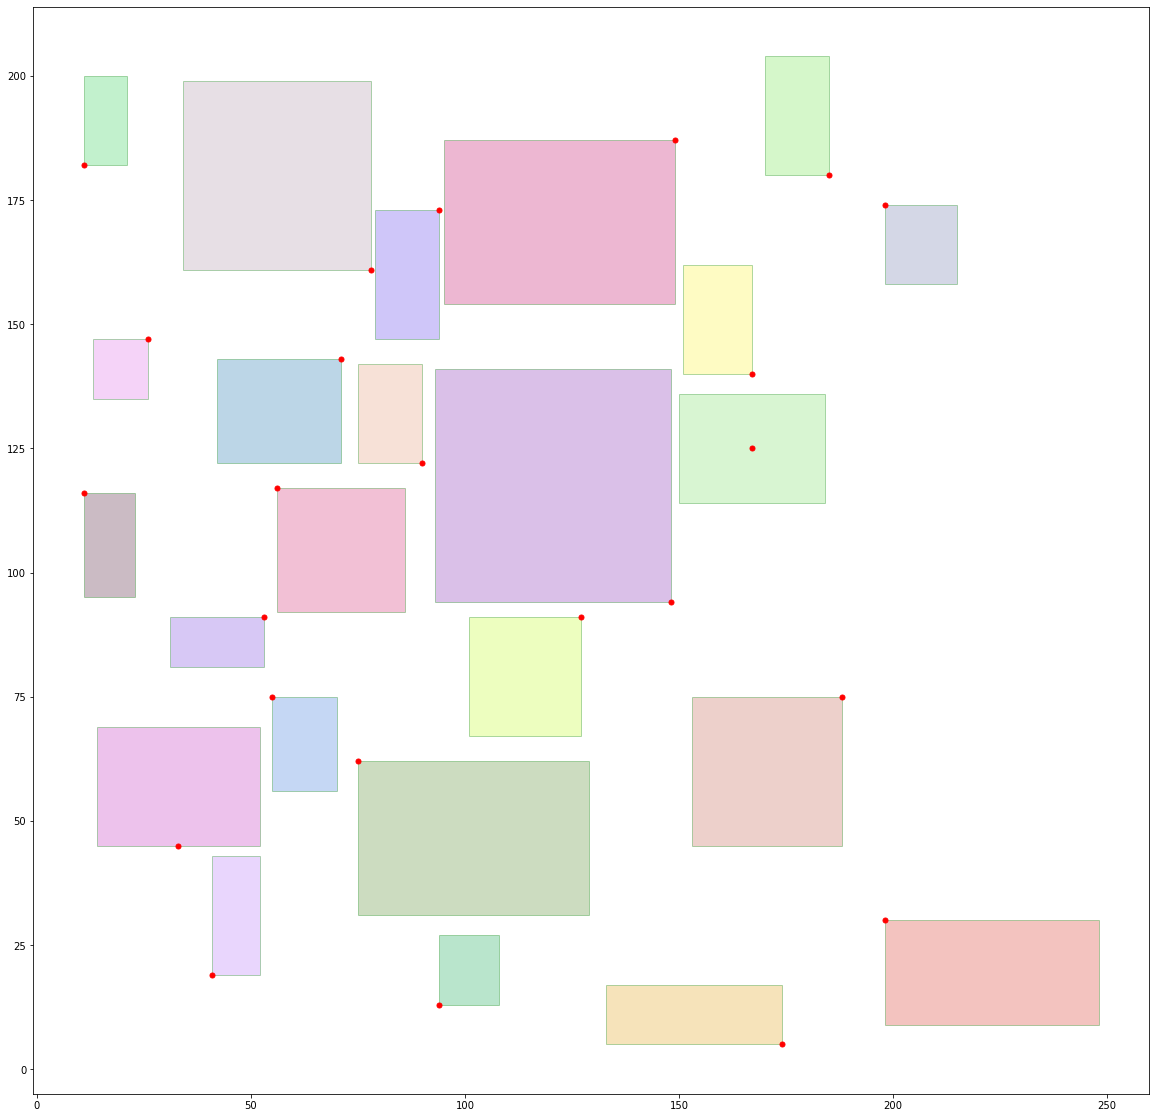

In [16]:
solve_label_placement('data/bin1.txt', (0, 250))

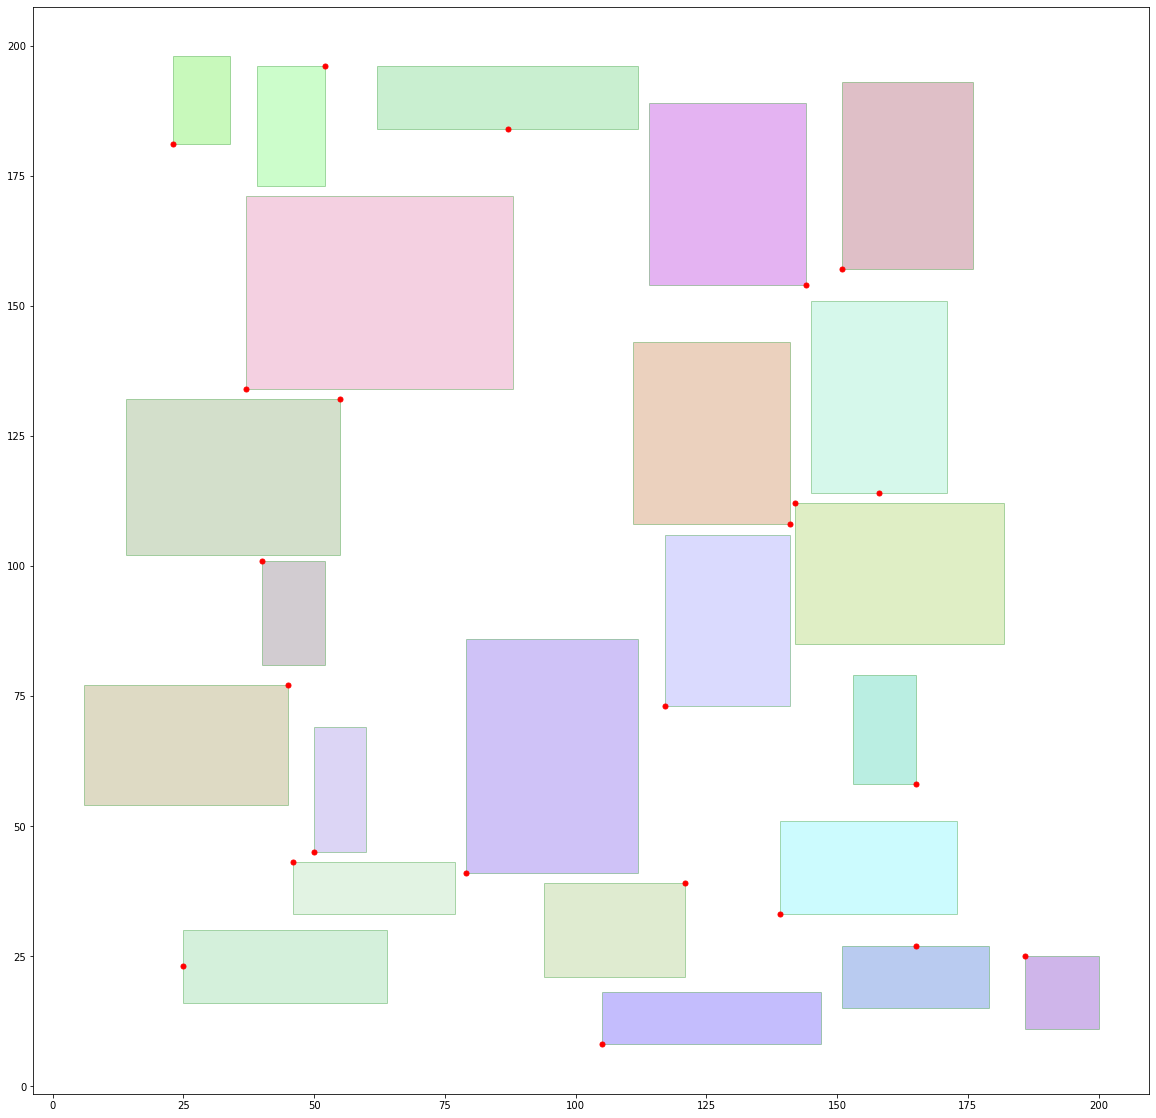

In [17]:
solve_label_placement('data/bin2.txt')

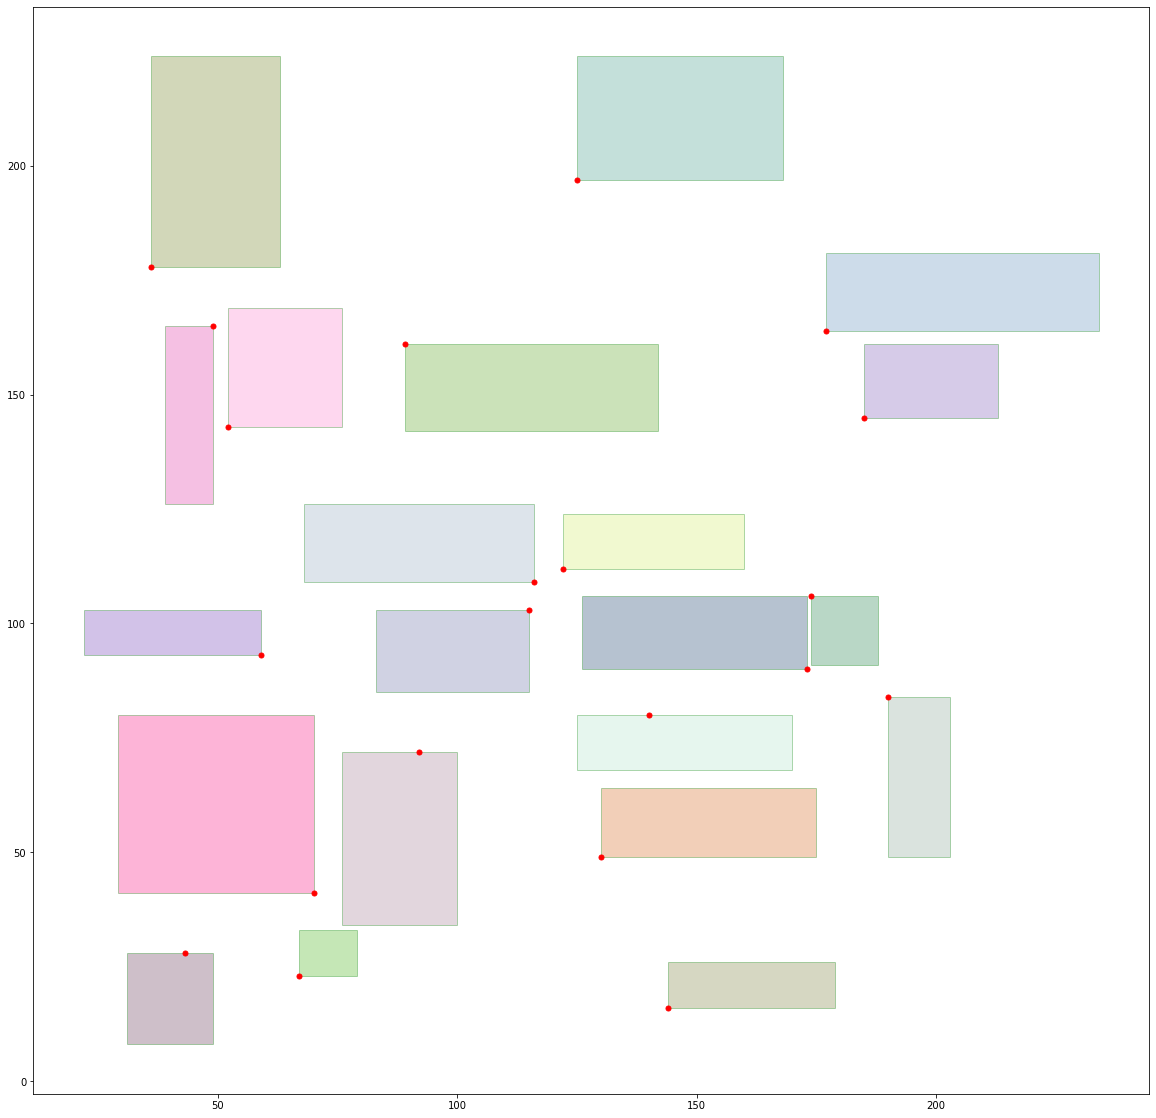

In [18]:
solve_label_placement('data/bin3.txt')

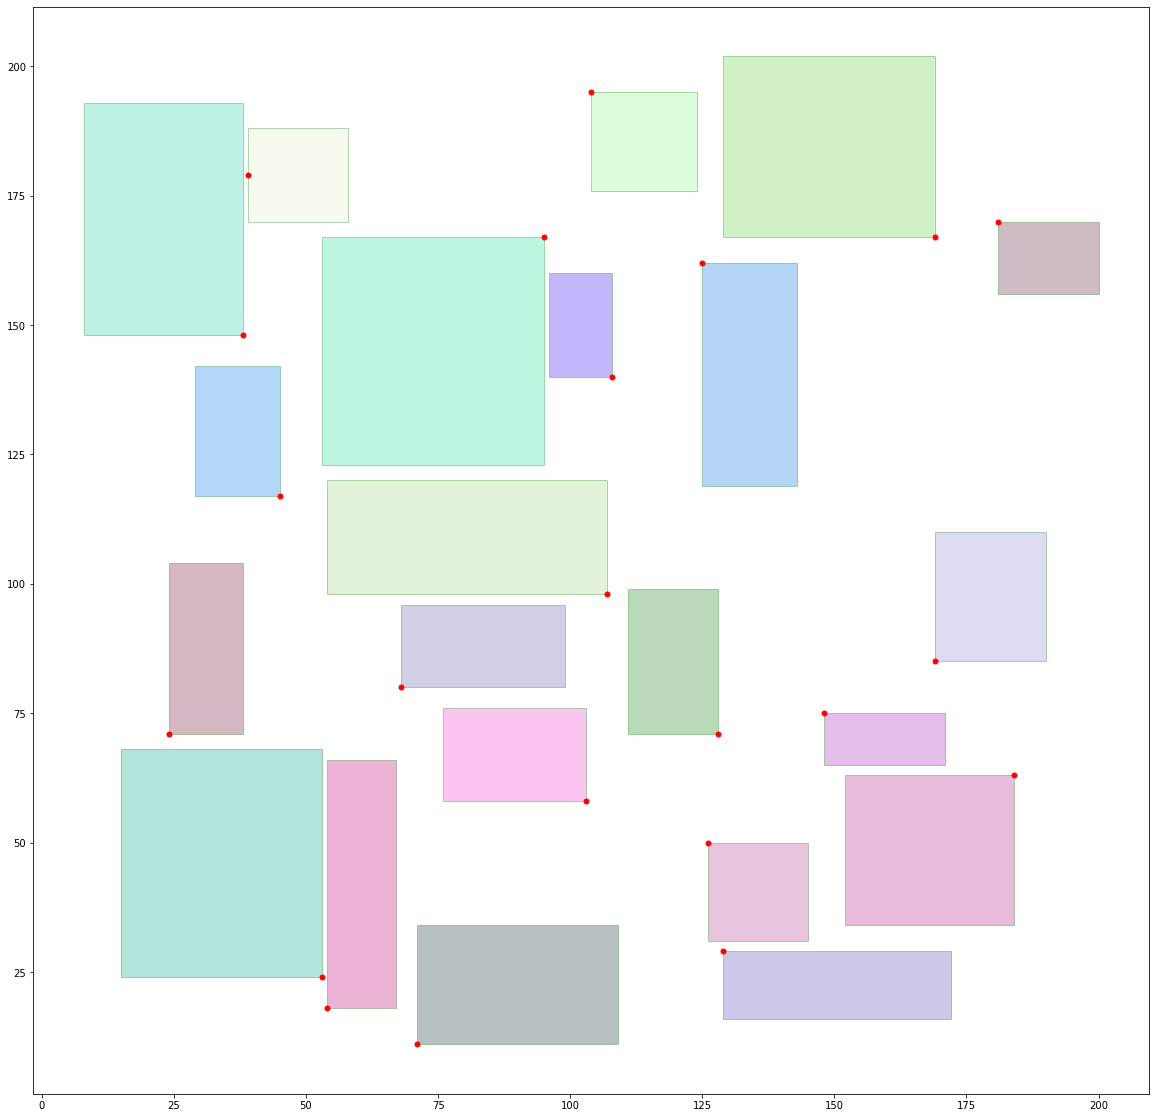

In [19]:
solve_label_placement('data/bin4.txt')

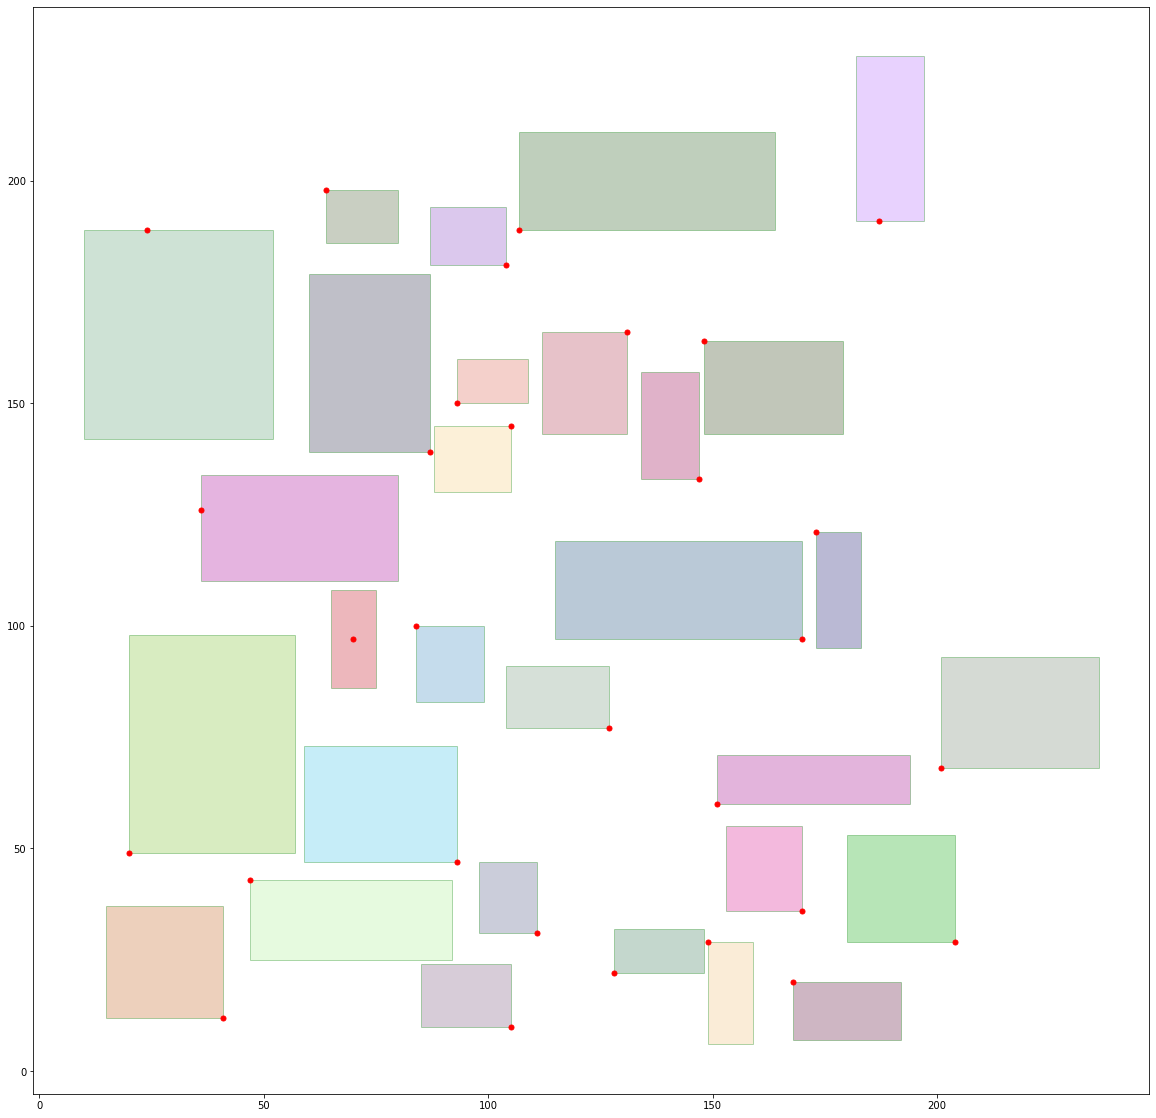

In [20]:
solve_label_placement('data/bin5.txt')